# Overview

In this notebook we will understand MC dropout which is a technique used to get uncertainty in deep neural network models. We will explain this using MC dropout for classification on MNIST dataset. We will even introduce and explain the concept of calibration error and compare the uncertainty between various models using this metric.



Standard deep learning tools for regression and classification do not capture model uncertainty. Standard deep learning tools for regression and classification do not capture model uncertainty.A model can be uncertain in its prediction even with high softmax output. A model can be uncertain in its prediction even with high softmax output.

# What is MC dropout ?

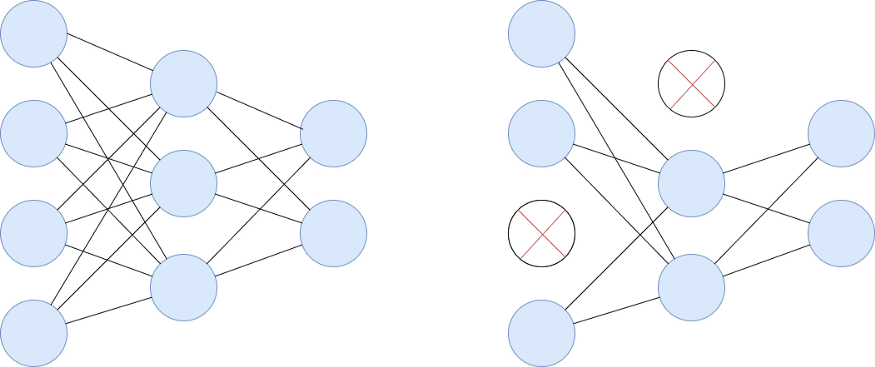

##### image reference:- https://towardsdatascience.com/monte-carlo-dropout-7fd52f8b6571

A model can be uncertain in its prediction even with high softmax output. Dropout is a regularization technique which prevents overfitting. In Dropout different set of neurons are switched off and each neuron has probability of getting off while training. In Dropout different set of neurons are switched off and each neuron has probability of getting off while training. In Dropout different set of neurons are switched off and each neuron has probability of getting off while training. MC Dropout can be thought as an ensemble model. Everytime different set of neurons are off with probability P. Hence each time the model is different and final output is the mean of many different neural network.

# Import Libraries

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, Conv2D
from tensorflow.keras.models import load_model

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


# Import Dataset
 
### Classification

#### Training models

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

### MonteCarlo Layer

In [3]:
class MonteCarloDropout(Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

### Model 1 

Describe model 1

In [4]:
def return_network1(index=1):
    
    layers=[MonteCarloDropout(rate=0.25),Dropout(rate=0.25)]
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(layers[index])
    model.add(keras.layers.Dense(300, activation="relu"))
    optimizer = keras.optimizers.Nadam(lr=0.001)
    model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer, metrics=["accuracy"])
    return model


In [5]:
model_mc1=return_network1(index=0)
model_mc1.fit(X_train, y_train, epochs=50)
model_mc1.save("models/model_mc1.h5")

C:\Users\Dell\anaconda3\lib\site-packages\keras\optimizer_v2\nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Epoch 1/50
1875/1875 [==============================] - 8s 4ms/step - loss: 7.2560 - accuracy: 0.1291
Epoch 2/50
1875/1875 [==============================] - 7s 4ms/step - loss: 5.6437 - accuracy: 0.1445
Epoch 3/50
1875/1875 [==============================] - 7s 4ms/step - loss: 5.5990 - accuracy: 0.1352
Epoch 4/50
1875/1875 [==============================] - 7s 4ms/step - loss: 5.5982 - accuracy: 0.1315
Epoch 5/50
1875/1875 [==============================] - 7s 4ms/step - loss: 5.4880 - accuracy: 0.1503
Epoch 6/50
1875/1875 [==============================] - 7s 4ms/step - loss: 5.5544 - accuracy: 0.1329
Epoch 7/50
1875/1875 [==============================] - 7s 4ms/step - loss: 5.5395 - accuracy: 0.1345
Epoch 8/50
1875/1875 [==============================] - 7s 4ms/step - loss: 5.4437 - accuracy: 0.1522
Epoch 9/50
1875/1875 [==============================] - 7s 4ms/step - loss: 5.5092 - accuracy: 0.1380
Epoch 10/50
1875/1875 [==============================] - 7s 4ms/step - loss: 5.647

### Testing

In [6]:
def test(num_predictions, model):
    T=100 #(NUMBER OF PREDICTIONS)
    predictions=[model.predict(X_test) for _ in range(T)]
    probability=np.stack(predictions).mean(axis=0)
    return predictions,probability


In [7]:
num_predictions=100
predictions1, probability1 = test(num_predictions, model_mc1)
y_pred=np.argmax(probability1, axis=1)
acc = np.mean(y_pred == y_test)
print(acc)

0.176


#### Calibration

In [8]:
def dict_make(dict_name,key,value):
    if(key in dict_name):
        dict_name[key].append(value)
    else:
        dict_name[key]=[]
        
def bin_allocate(probability):
    max_prob=np.max(probability, axis=1)
    indexes={}
    for i in range(len(max_prob)):    
        if(max_prob[i]<0.1):
            dict_make(indexes,0.1,i)
        elif(max_prob[i]<0.2):
            dict_make(indexes,0.2,i)
        elif(max_prob[i]<0.3):
            dict_make(indexes,0.3,i)
        elif(max_prob[i]<0.4):
            dict_make(indexes,0.4,i)
        elif(max_prob[i]<0.5):
            dict_make(indexes,0.5,i)
        elif(max_prob[i]<0.6):
            dict_make(indexes,0.6,i)
        elif(max_prob[i]<0.7):
            dict_make(indexes,0.7,i)
        elif(max_prob[i]<0.8):
            dict_make(indexes,0.8,i)
        elif(max_prob[i]<0.9):
            dict_make(indexes,0.9,i)
        else:
            dict_make(indexes,1,i)
            
    return indexes

def plot_samples(indexes):
    keys = indexes.keys()
    values = [len(indexes[key])/len(X_test) for key in indexes]
    plt.bar(keys, values,width=-0.1,align='edge',edgecolor='black')
    plt.xlabel('Confidence range')
    plt.ylabel('Ratio of no of samples')
        

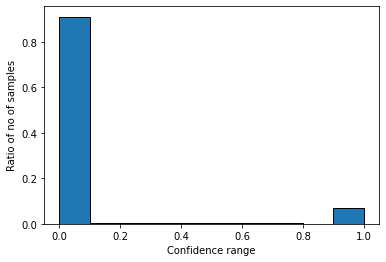

In [9]:
indexes1=bin_allocate(probability1)
plot_samples(indexes1)

In [10]:
def calculate_avg_acc(probability,indexes):
    accuracy={}
    max_prob=np.max(probability,axis=1)
    prob={}
    for key in indexes:
        accuracy[key]=0
        prob[key]=0
        for i in indexes[key]:
            if(y_pred[i]==y_test[i]):
                accuracy[key]+=1
            prob[key]+=max_prob[i]
        prob[key]=prob[key]/len(indexes[key])
        accuracy[key]=accuracy[key]/len(indexes[key])
    return prob,accuracy

def plot_calibration(prob,accuracy):        
    plt.bar(prob.keys(),prob.values(),width=-0.1,align='edge',alpha=0.5,edgecolor='black')
    plt.bar(accuracy.keys(),accuracy.values(),width=-0.1,align='edge',alpha=0.1,edgecolor='black')
    plt.legend(['Confidence','Accuracy'],loc=2)
    plt.xlabel('Confidence range')
    plt.ylabel('Average Value')

def expected_calibration_error(accuracy,prob,indexes):
    ece=0
    for key in accuracy.keys():
        ece=+len(indexes[key])*(np.abs(accuracy[key]-prob[key]))
    return ece

def maximum_calibration_error(accuracy,prob):
    mce=0
    for key in accuracy.keys():
        mce=np.maximum(np.abs(accuracy1[key]-prob1[key]),mce)
    return mce

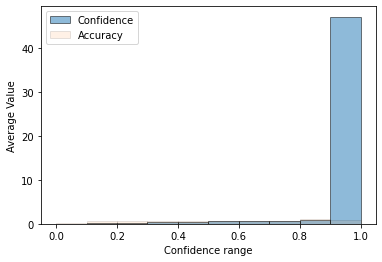

In [11]:
prob1,accuracy1=calculate_avg_acc(probability1,indexes1)
plot_calibration(prob1,accuracy1)

In [12]:
ece=expected_calibration_error(accuracy1,prob1,indexes1)/len(y_test)
mce=maximum_calibration_error(accuracy1,prob1)
print(ece)
print(mce)


0.00015200642347335813
46.20615993170427


### Model 2

In [13]:
def return_network2(index=1):
    
    layers=[MonteCarloDropout(rate=0.25),Dropout(rate=0.25)]
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(layers[index])
    model.add(keras.layers.Dense(300, activation="relu"))
    model.add(layers[index])
    model.add(keras.layers.Dense(300, activation="relu"))
    model.add(layers[index])
    model.add(keras.layers.Dense(10, activation="softmax"))
    optimizer = keras.optimizers.Nadam(lr=0.001)
    model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer, metrics=["accuracy"])
    
    return model

In [14]:
model_mc2=return_network2(index=0)
model_mc2.fit(X_train, y_train, epochs=50)
model_mc2.save("models/model_mc2.h5")

Epoch 1/50
1875/1875 [==============================] - 10s 5ms/step - loss: 4.1559 - accuracy: 0.7649
Epoch 2/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.5630 - accuracy: 0.8576
Epoch 3/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3915 - accuracy: 0.8932
Epoch 4/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3624 - accuracy: 0.9021
Epoch 5/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3380 - accuracy: 0.9116
Epoch 6/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3306 - accuracy: 0.9137
Epoch 7/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3119 - accuracy: 0.9201
Epoch 8/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3120 - accuracy: 0.9209
Epoch 9/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2960 - accuracy: 0.9251
Epoch 10/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.

In [15]:
num_predictions=100
predictions2, probability2 = test(num_predictions, model_mc2)
y_pred=np.argmax(probability2, axis=1)
acc = np.mean(y_pred == y_test)
print(acc)

0.9712


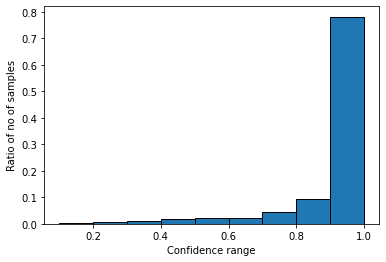

In [16]:
indexes2=bin_allocate(probability2)
plot_samples(indexes2)

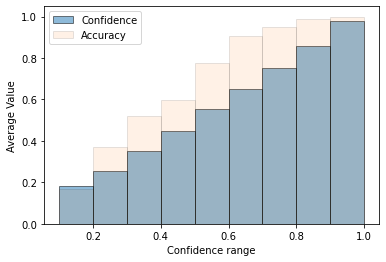

In [17]:
prob2,accuracy2=calculate_avg_acc(probability2,indexes2)
plot_calibration(prob2,accuracy2)

In [18]:
ece=expected_calibration_error(accuracy2,prob2,indexes2)/len(y_test)
mce=maximum_calibration_error(accuracy2,prob2)
print(ece)
print(mce)

3.017636537551884e-05
46.20615993170427


### Model 3

In [19]:
def return_network3(index=1):
    
    layers=[MonteCarloDropout(rate=0.25),Dropout(rate=0.25)]
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28,1)))
    model.add(layers[index])
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(300, activation="relu"))
    model.add(layers[index])
    model.add(keras.layers.Dense(10, activation="softmax"))
    optimizer = keras.optimizers.Nadam(lr=0.001)
    model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer, metrics=["accuracy"])
    
    return model


In [20]:

model_mc3=return_network3(index=0)
model_mc3.fit(X_train.reshape((X_train.shape[0], 28, 28, 1)), y_train, epochs=5)
model_mc3.save("models/model_mc3.h5")

Epoch 1/5
1875/1875 [==============================] - 271s 144ms/step - loss: 3.5979 - accuracy: 0.5974
Epoch 2/5
1875/1875 [==============================] - 270s 144ms/step - loss: 1.0296 - accuracy: 0.7081
Epoch 3/5
1875/1875 [==============================] - 271s 144ms/step - loss: 0.6659 - accuracy: 0.8234
Epoch 4/5
1875/1875 [==============================] - 273s 146ms/step - loss: 0.4615 - accuracy: 0.8821
Epoch 5/5
1875/1875 [==============================] - 272s 145ms/step - loss: 0.3551 - accuracy: 0.9092


In [21]:
num_predictions=100
predictions3, probability3 = test(num_predictions, model_mc3)
y_pred=np.argmax(probability3, axis=1)
acc = np.mean(y_pred == y_test)
print(acc)

0.9593


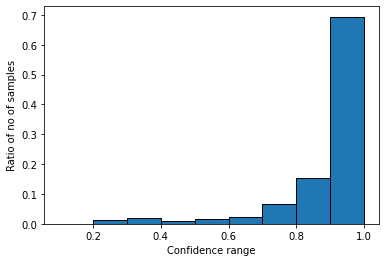

In [22]:
indexes3=bin_allocate(probability3)
plot_samples(indexes3)

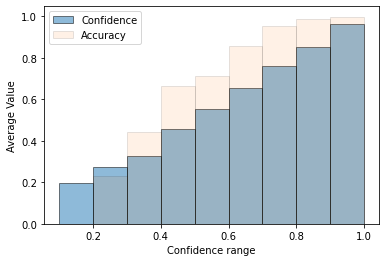

In [23]:
prob3,accuracy3=calculate_avg_acc(probability3,indexes3)
plot_calibration(prob3,accuracy3)

In [24]:
ece=expected_calibration_error(accuracy3,prob3,indexes3)/len(y_test)
mce=maximum_calibration_error(accuracy3,prob3)
print(ece)
print(mce)

3.947368860244751e-05
46.20615993170427
